# AUEB M.Sc. in Data Science (part-time)

### 2024.04 - 2024.06

## PART 04
### PROJECT 02: Implementing Bi-Directional Stacked RNN (GRU or LSTM) in Keras/TensorFlow for POS Tagging


**Course**: Text Analytics   
**Authors**:
Anagnos Theodoros (p3352323) -
Michalopoulos Ioannis (p3352314) -
Kafantaris Panagiotis (p3352328) -  
Vigkos Ioannis (p3352326)

**Date**: 2024-05-25

### Libraries

In [ ]:
!nvidia-smi

Thu May 30 18:58:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install conllu

In [ ]:
## Data Handling and Parsing
import os
from conllu import parse
import requests
from collections import Counter
import numpy as np

## Word Embeddings
import gensim.downloader as api

## Preprocessing
from nltk.util import ngrams
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## Metrics and Evaluation
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.exceptions import UndefinedMetricWarning

## Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, Input, LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.regularizers import l2

## Plotting
import matplotlib.pyplot as plt

## Other
import warnings

### Functions

In [ ]:
# Function for downloading dataset
def download_dataset(url, filename):
    response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(response.content)

In [ ]:
# Function for parsing and printing head and tail of the dataset
def print_head_tail(file_path, num_lines=5):
    with open(file_path, "r", encoding="utf-8") as f:
        data = f.readlines()
        # Printing head of the dataset
        print(f"Head of {file_path}:")
        print("".join(data[:num_lines]))
        print("\n")
        # Printing tail of the dataset
        print(f"Tail of {file_path}:")
        print("".join(data[-num_lines:]))
        print("\n")

In [ ]:
# Function for parsing conllu files and extracting sentences
def parse_conllu(file_path):
    """
    Parsed the given conllu file and extracted sentences using the 'conllu' library.
    """
    # Opening the file in read mode with UTF-8 encoding
    with open(file_path, "r", encoding="utf-8") as f:
        # Reading the entire content of the file
        data = f.read()
        # Parsing the data to extract sentences using the 'conllu' library
        sentences = parse(data)
    # Returning the list of parsed sentences
    return sentences

In [ ]:
# Function for parsing and printing head and tail of the dataset along with initial document length
def print_head_tail_with_length(file_path, num_lines=5):
    with open(file_path, "r", encoding="utf-8") as f:
        data = f.readlines()
        # Calculating the initial document length (number of sentences)
        initial_document_length = sum(1 for line in data if line.strip() == "")
        # Printing head of the dataset
        print(f"Head of {file_path}:")
        print("".join(data[:num_lines]))
        print("\n")
        # Printing tail of the dataset
        print(f"Tail of {file_path}:")
        print("".join(data[-num_lines:]))
        print("\n")
        # Printing the initial document length
        print(f"Initial Document Length (number of sentences) for {file_path}: {initial_document_length}\n")

In [ ]:
# Function for extracting words and tags from parsed sentences
def extract_words_and_tags(sentences):
    """
    Extracted words and corresponding POS tags from parsed sentences.
    """
    words = []
    tags = []
    # Iterating over each parsed sentence
    for sentence in sentences:
        sentence_words = []
        sentence_tags = []
        # Iterating over each token in the sentence
        for token in sentence:
            if token['form'] and token['upostag']:
                sentence_words.append(token['form'])  # Extracting the word form
                sentence_tags.append(token['upostag'])  # Extracting the POS tag
        # Appending the extracted words and tags to their respective lists
        words.append(sentence_words)
        tags.append(sentence_tags)
    # Returning the lists of words and tags
    return words, tags

In [ ]:
# Function for converting all words to lowercase
def convert_to_lowercase(words):
    return [[word.lower() for word in sentence] for sentence in words]

In [ ]:
# Function to flatten a nested list
def list_flat_data(alist):
    """
    Flatten a nested list into a single list.
    """
    flat_list = []
    for sublist in alist:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [ ]:
# Function to convert to windowed dataset
def convert_to_window_dataset(data, window_size, pad_symbol='</s>'):
    """
    Converted sentences and POS tags to a windowed dataset with padding.
    """
    z_sentences = data[0]  # Extracted sentences
    z_pos_tags = list_flat_data(data[1])  # Flattened POS tags

    windowed_sentences = []  # Initialized list to hold windowed sentences

    # Iterated over each sentence in the dataset
    for sentence in z_sentences:
        # Generated n-grams for each sentence with padding
        gen = ngrams(sentence, window_size, pad_left=True, pad_right=True, left_pad_symbol=pad_symbol, right_pad_symbol=pad_symbol)

        # Appended the generated windows to the list, skipping initial and final padding windows
        for f in list(gen)[window_size//2:-(window_size//2)]:
            windowed_sentences.append(f)

    return windowed_sentences, z_pos_tags

In [ ]:
# Function to create vocabulary from the flattened windows
def create_vocabulary_from_windows(windows):
    """
    Create a vocabulary from the flattened windows.

    Parameters:
    - windows (list of list of str): The windowed data containing words.

    Returns:
    - vocabulary (dict): A dictionary mapping each unique word to a unique index.
    """
    # Flatten the windowed data
    flat_windows = list_flat_data(windows)

    # Get all unique words in the data set and make a vocabulary out of them
    vocab = set(flat_windows)
    vocabulary = {v: k for k, v in enumerate(vocab)}

    return vocabulary

In [ ]:
def create_embedding_matrix(vocab, wv, embedding_dim=300):
    """
    Create an embedding matrix for the vocabulary using pre-trained word embeddings.

    Parameters:
    - vocab (dict): The vocabulary mapping words to indices.
    - wv (KeyedVectors): The pre-trained word vectors.
    - embedding_dim (int): The dimensionality of the embeddings. Default is 300.

    Returns:
    - embedding_matrix (np.array): The embedding matrix where each row corresponds to a word's embedding.
    """
    # Initializing the embedding matrix with zeros
    embedding_matrix = np.zeros((len(vocab), embedding_dim))

    # Populating the embedding matrix with vectors from the pre-trained model
    for word, idx in vocab.items():
        if word in wv:
            embedding_matrix[idx] = wv[word]

    return embedding_matrix

In [ ]:
# Defining a function to convert windows of words to tokenized format using the vocabulary
def tokenize_windows(windows, vocab):
    # Initializing an empty list to hold tokenized windows
    tokenized_windows = []

    # Iterating over each sentence in the windows
    for sentence in windows:
        # Initializing an empty list to hold tokenized sentence
        tokenized_sentence = []

        # Iterating over each token in the sentence
        for token in sentence:
            # Checking if the token is in the vocabulary and appending its index, otherwise using the index of '</s>'
            if token in vocab:
                tokenized_sentence.append(vocab[token])
            else:
                tokenized_sentence.append(vocab['</s>'])

        # Appending the tokenized sentence to the list of tokenized windows
        tokenized_windows.append(tokenized_sentence)

    # Returning the list of tokenized windows
    return tokenized_windows

## Data Preprocessing

### Downloading the dataset and parsing the conllu files to extract sentences, words, and POS tags

In [ ]:
# Defining URLs of the datasets for training, development, and testing
urls = {
    "train": "https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-train.conllu",
    "dev": "https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-dev.conllu",
    "test": "https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-test.conllu"
}

In [ ]:
# Downloading each dataset and saving it locally
for key, url in urls.items():
    filename = f"en_ewt_{key}.conllu"
    download_dataset(url, filename)

In [ ]:
# Printing dataset names
print("Downloaded datasets:")
for key in urls.keys():
    print(f"en_ewt_{key}.conllu")

Downloaded datasets:
en_ewt_train.conllu
en_ewt_dev.conllu
en_ewt_test.conllu


In [ ]:
# Printing dataset names
print("Downloaded datasets:")
for key in urls.keys():
    print(f"en_ewt_{key}.conllu")

# Printing head, tail, and initial document length for each dataset
for key in urls.keys():
    filename = f"en_ewt_{key}.conllu"
    print("-----------\n")
    print_head_tail_with_length(filename)

Downloaded datasets:
en_ewt_train.conllu
en_ewt_dev.conllu
en_ewt_test.conllu
-----------

Head of en_ewt_train.conllu:
# newdoc id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000
# sent_id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001
# newpar id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-p0001
# text = Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town of Qaim, near the Syrian border.
1	Al	Al	PROPN	NNP	Number=Sing	0	root	0:root	SpaceAfter=No



Tail of en_ewt_train.conllu:
23	my	my	PRON	PRP$	Case=Gen|Number=Sing|Person=1|Poss=Yes|PronType=Prs	24	nmod:poss	24:nmod:poss	_
24	car	car	NOUN	NN	Number=Sing	21	obl	21:obl:on	SpaceAfter=No
25	)	)	PUNCT	-RRB-	_	10	punct	10:punct	SpaceAfter=No
26	.	.	PUNCT	.	_	4	punct	4:punct	_




Initial Document Length (number of sentences) for en_ewt_train.conllu: 12544

-----------

Head of en_ewt_dev.conllu:
# newdoc id = weblog-blogspot.com_nom

Parsed the training, development, and test datasets to extract words and POS tags. Converted all words to lowercase for consistency and printed sample data for verification.

In [ ]:
# Parsing the training, development, and test datasets
train_sentences = parse_conllu("en_ewt_train.conllu")
dev_sentences = parse_conllu("en_ewt_dev.conllu")
test_sentences = parse_conllu("en_ewt_test.conllu")

# Printing sample parsed sentences for verification
print("Sample parsed sentences from training data:")
print(train_sentences[120:140])
print("\n")

# Extracting words and tags from the parsed sentences
train_words, train_tags = extract_words_and_tags(train_sentences)
dev_words, dev_tags = extract_words_and_tags(dev_sentences)
test_words, test_tags = extract_words_and_tags(test_sentences)

# Printing set sizes
print("Size of train_words:", len(train_words))
print("Size of train_tags:", len(train_tags))
print("\n")
# Printing set sizes
print("Size of dev_words:", len(dev_words))
print("Size of dev_tags:", len(dev_tags))
print("\n")
# Printing set sizes
print("Size of test_words:", len(test_words))
print("Size of test_tags:", len(test_tags))
print("\n")

# Converting all words to lowercase
train_words = convert_to_lowercase(train_words)
dev_words = convert_to_lowercase(dev_words)
test_words = convert_to_lowercase(test_words)

# Printing sample extracted words and tags for verification
print("Sample words and tags from training data:")
print("Words:", train_words[0])
print("Tags:", train_tags[0])
print("\n")

print("Sample words and tags from development data:")
print("Words:", dev_words[0])
print("Tags:", dev_tags[0])
print("\n")

print("Sample words and tags from test data:")
print("Words:", test_words[0])
print("Tags:", test_tags[0])
print("\n")

Sample parsed sentences from training data:
[TokenList<Don't, Do, n't, have, to, mention, what, radiation, has, done, and, is, still, doing, to, Hirsohima, &, Nagaski, folks, --, there, can, be, no, doubts, about, the, effects, of, radiation, in, Chernobyl, ......., metadata={sent_id: "weblog-typepad.com_ripples_20040407125600_ENG_20040407_125600-0056", text: "Don't have to mention what radiation has done and is still doing to Hirsohima & Nagaski folks--there can be no doubts about the effects of radiation in Chernobyl......."}>, TokenList<The, Chernobyl, Children's, Children, 's, Project, (, http://www.adiccp.org/home/default.asp, ), offers, several, ways, to, help, the, children, of, that, region, ., metadata={sent_id: "weblog-typepad.com_ripples_20040407125600_ENG_20040407_125600-0057", text: "The Chernobyl Children's Project (http://www.adiccp.org/home/default.asp) offers several ways to help the children of that region."}>, TokenList<One, of, them, is, the, Rest, and, Recuperation

### Creating sliding windows for words and align the corresponding tags

In [ ]:
# Example window size
window_size = 5

# Creating sliding windows for train and dev datasets
train_windows, train_window_tags = convert_to_window_dataset((train_words, train_tags), window_size)
dev_windows, dev_window_tags = convert_to_window_dataset((dev_words, dev_tags), window_size)
test_windows, test_window_tags = convert_to_window_dataset((test_words, test_tags), window_size)

# Printing sample windowed sentences and tags for verification
print("Sample windowed sentences from training data:\n")
print("Windows:", train_windows[:25])
print("\n")
print("Tags:", train_window_tags[:25])
print("\n")

# Printing sample windowed sentences and tags for verification
print("Sample windowed sentences from training data:\n")
for i in range(5):
    print(f"Window {i+1}: {train_windows[i]}")
    print(f"Tags {i+1}: {train_window_tags[i]}")
    print("\n")

print("Sample windowed sentences from development data:\n")
for i in range(5):
    print(f"Window {i+1}: {dev_windows[i]}")
    print(f"Tags {i+1}: {dev_window_tags[i]}")
    print("\n")

# Printing sizes of the windowed datasets
print("Size of train_windows:", len(train_windows))
print("Size of train_window_tags:", len(train_window_tags))
print("\n")
print("Size of dev_windows:", len(dev_windows))
print("Size of dev_window_tags:", len(dev_window_tags))

Sample windowed sentences from training data:

Windows: [('</s>', '</s>', 'al', '-', 'zaman'), ('</s>', 'al', '-', 'zaman', ':'), ('al', '-', 'zaman', ':', 'american'), ('-', 'zaman', ':', 'american', 'forces'), ('zaman', ':', 'american', 'forces', 'killed'), (':', 'american', 'forces', 'killed', 'shaikh'), ('american', 'forces', 'killed', 'shaikh', 'abdullah'), ('forces', 'killed', 'shaikh', 'abdullah', 'al'), ('killed', 'shaikh', 'abdullah', 'al', '-'), ('shaikh', 'abdullah', 'al', '-', 'ani'), ('abdullah', 'al', '-', 'ani', ','), ('al', '-', 'ani', ',', 'the'), ('-', 'ani', ',', 'the', 'preacher'), ('ani', ',', 'the', 'preacher', 'at'), (',', 'the', 'preacher', 'at', 'the'), ('the', 'preacher', 'at', 'the', 'mosque'), ('preacher', 'at', 'the', 'mosque', 'in'), ('at', 'the', 'mosque', 'in', 'the'), ('the', 'mosque', 'in', 'the', 'town'), ('mosque', 'in', 'the', 'town', 'of'), ('in', 'the', 'town', 'of', 'qaim'), ('the', 'town', 'of', 'qaim', ','), ('town', 'of', 'qaim', ',', 'near'),

### Creating a vocabulary from the train set

A vocabulary is needed to convert words into unique numerical indices, allowing consistent and efficient lookup for embeddings and ensuring uniformity across the dataset.

In [ ]:
# Creating the vocabulary
vocabulary = create_vocabulary_from_windows(train_windows + dev_windows + test_windows)

# Printing the vocabulary for verification
print("Word Vocabulary (first 30 items):\n", list(vocabulary.items())[:30])
print("\n")
print("Word Vocabulary (last 30 items):\n", list(vocabulary.items())[-30:])
print("\n")

# Printing sizes of the vocabularies
print("Size of Word Vocabulary:\n", len(vocabulary))

Word Vocabulary (first 30 items):
 [('extreme', 0), ('03/29/2001', 1), ('deleted', 2), ('veryyyy', 3), ('beliefs', 4), ('lynne', 5), ('mercenaries', 6), ('tomipilates', 7), ('toby', 8), ('undergraduate', 9), ('proviso', 10), ('110', 11), ('govs', 12), ('garner', 13), ('3143c', 14), ('oops', 15), ('nurses', 16), ('kang', 17), ('rides', 18), ("78's", 19), ('producers', 20), ('ruthless', 21), ('excel', 22), ('blocks', 23), ('jaffna', 24), ('gross', 25), ('parole', 26), ('4,223,000', 27), ('arabian', 28), ('thane', 29)]


Word Vocabulary (last 30 items):
 [('easiest', 19854), ('fertilized', 19855), ('e.g.', 19856), ('adhamiya', 19857), ('abacus', 19858), ('mirror', 19859), ('about', 19860), ('prisoners', 19861), ('russians', 19862), ('statement', 19863), ('abiding', 19864), ('chevron', 19865), ('ballerina', 19866), ('incomes', 19867), ('malaysian', 19868), ('damascus', 19869), ('locals', 19870), ('disability', 19871), ('satisfying', 19872), ('gloating', 19873), ('vangie', 19874), ('functio

In [ ]:
# Create a vocabulary for train_window_tags
train_target = set(train_window_tags)
train_target = {v: k for k, v in enumerate(train_target)}

# Print samples and sizes for verification
print("Sample of train_window_tags (first 5):", train_window_tags[:5])
print("Size of train_target vocabulary:", len(train_target))

# Printing a sample of the train_target vocabulary
print("Sample of train_target vocabulary (first 10 items):", list(train_target.items())[:10])

Sample of train_window_tags (first 5): ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ']
Size of train_target vocabulary: 18
Sample of train_target vocabulary (first 10 items): [('PRON', 0), ('SYM', 1), ('_', 2), ('VERB', 3), ('DET', 4), ('PUNCT', 5), ('NOUN', 6), ('PART', 7), ('CCONJ', 8), ('AUX', 9)]


### Load pre-trained word embeddings (Word2Vec)

In [ ]:
# Loading pre-trained Word2Vec embeddings
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


### Mapping the words in the windows to their corresponding embeddings

In [ ]:
# Creating the embedding matrix for the vocabulary
embedding_matrix = create_embedding_matrix(vocabulary, wv)

# Printing a sample of the embedding matrix
print("Sample embeddings:\n", embedding_matrix[:5])

Sample embeddings:
 [[ 0.07519531 -0.00389099 -0.07568359 ...  0.34765625 -0.04858398
   0.21289062]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.17285156 -0.04785156  0.31640625 ... -0.36132812 -0.05053711
  -0.07080078]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.01696777 -0.33398438  0.41992188 ...  0.3125      0.24511719
   0.08837891]]


### Tokenizing the train and dev windows using the created vocabulary

In [ ]:
# Tokenizing the train, dev, and test windows
train_windows_tokenized = tokenize_windows(train_windows, vocabulary)
dev_windows_tokenized = tokenize_windows(dev_windows, vocabulary)
test_windows_tokenized = tokenize_windows(test_windows, vocabulary)

# Printing sample tokenized train windows for verification
print("Sample tokenized train windows (first 25):\n", train_windows_tokenized[:25])
print("\n")

# Printing sample tokenized dev windows for verification
print("Sample tokenized dev windows (first 25):\n", dev_windows_tokenized[:25])
print("\n")

# Printing sizes of tokenized windows for verification
print("Size of tokenized train windows:", len(train_windows_tokenized))
print("Size of tokenized dev windows:", len(dev_windows_tokenized))
print("\n")

# Printing a sample of the tag-to-index mapping
target_sample = list(train_target.items())[:25]
print("Sample target (tag to index):\n", target_sample)
print("Size of target dictionary:", len(train_target))

Sample tokenized train windows (first 25):
 [[19282, 19282, 2884, 9120, 15955], [19282, 2884, 9120, 15955, 6678], [2884, 9120, 15955, 6678, 9508], [9120, 15955, 6678, 9508, 12091], [15955, 6678, 9508, 12091, 13577], [6678, 9508, 12091, 13577, 8397], [9508, 12091, 13577, 8397, 202], [12091, 13577, 8397, 202, 2884], [13577, 8397, 202, 2884, 9120], [8397, 202, 2884, 9120, 6354], [202, 2884, 9120, 6354, 6297], [2884, 9120, 6354, 6297, 7080], [9120, 6354, 6297, 7080, 5801], [6354, 6297, 7080, 5801, 6847], [6297, 7080, 5801, 6847, 7080], [7080, 5801, 6847, 7080, 12461], [5801, 6847, 7080, 12461, 8807], [6847, 7080, 12461, 8807, 7080], [7080, 12461, 8807, 7080, 2543], [12461, 8807, 7080, 2543, 1100], [8807, 7080, 2543, 1100, 19253], [7080, 2543, 1100, 19253, 6297], [2543, 1100, 19253, 6297, 8994], [1100, 19253, 6297, 8994, 7080], [19253, 6297, 8994, 7080, 9618]]


Sample tokenized dev windows (first 25):
 [[19282, 19282, 5468, 7080, 236], [19282, 5468, 7080, 236, 14460], [5468, 7080, 236, 144

### Encoding the POS tags using LabelEncoder and OneHotEncoder

In [ ]:
# Initializing LabelEncoder and OneHotEncoder
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse_output=False)

# Fitting the LabelEncoder on the train tags and transforming all sets
train_tags_encoded = label_encoder.fit_transform(train_window_tags).reshape(-1, 1)
dev_tags_encoded = label_encoder.transform(dev_window_tags).reshape(-1, 1)

# Fitting the OneHotEncoder on the train tags and transforming all sets
train_tags_onehot = onehot_encoder.fit_transform(train_tags_encoded)
dev_tags_onehot = onehot_encoder.transform(dev_tags_encoded)

# Printing sample encoded and one-hot encoded tags for verification
print("Sample encoded train tags (first 10):\n", train_tags_encoded[:10].flatten())
print("Sample one-hot encoded train tags (first 5):\n", train_tags_onehot[:5])
print("Sample encoded dev tags (first 10):\n", dev_tags_encoded[:10].flatten())
print("Sample one-hot encoded dev tags (first 5):\n", dev_tags_onehot[:5])
print ("\n")

# Printing sizes of the encoded and one-hot encoded tags
print("Shape of encoded train tags:", train_tags_encoded.shape)
print("Shape of one-hot encoded train tags:", train_tags_onehot.shape)
print("Shape of encoded dev tags:", dev_tags_encoded.shape)
print("Shape of one-hot encoded dev tags:", dev_tags_onehot.shape)

Sample encoded train tags (first 10):
 [11 12 11 12  0  7 15 11 11 11]
Sample one-hot encoded train tags (first 5):
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Sample encoded dev tags (first 10):
 [ 1  5 11 15  5  7 12 11 11  1]
Sample one-hot encoded dev tags (first 5):
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Shape of encoded train tags: (207229, 1)
Shape of one-hot encoded train tags: (207229, 18)
Shape of encoded dev tags: (25512, 1)
Shape of one-hot encoded dev tags: (25512, 18)


## Baseline Model

### Most Frequent Class (MFC) Baseline

In [ ]:
# Step 1: Calculating the most frequent tag in the training data

# Flattening the list of tags from the training data for analysis
all_train_tags = list_flat_data(train_tags)

# Counting the frequency of each tag
tag_counter = Counter(all_train_tags)

# Finding the most frequent tag
most_frequent_tag = tag_counter.most_common(1)[0][0]

# Printing the most frequent tag
print(f"The most frequent tag in the training data is: {most_frequent_tag}")

# Step 2: Implementing the baseline model

# Creating baseline predictions by tagging each word with the most frequent tag
baseline_predictions = [most_frequent_tag] * len(list_flat_data(test_tags))

# Flattening the list of actual tags from the test set for evaluation
flat_test_tags = list_flat_data(test_tags)

# Step 3: Evaluating the baseline model

# Calculating the accuracy of the baseline model
baseline_accuracy = accuracy_score(flat_test_tags, baseline_predictions)

# Printing the baseline model accuracy
print(f"Baseline Model Accuracy: {baseline_accuracy}")

# Generating a comprehensive classification report with zero_division parameter
baseline_classification_report = classification_report(flat_test_tags, baseline_predictions, zero_division=0)

# Printing the classification report
print("\nClassification Report for the Baseline Model:\n")
print(baseline_classification_report)

The most frequent tag in the training data is: NOUN
Baseline Model Accuracy: 0.1625540275049116

Classification Report for the Baseline Model:

              precision    recall  f1-score   support

         ADJ       0.00      0.00      0.00      1788
         ADP       0.00      0.00      0.00      2034
         ADV       0.00      0.00      0.00      1176
         AUX       0.00      0.00      0.00      1543
       CCONJ       0.00      0.00      0.00       737
         DET       0.00      0.00      0.00      1897
        INTJ       0.00      0.00      0.00       120
        NOUN       0.16      1.00      0.28      4137
         NUM       0.00      0.00      0.00       542
        PART       0.00      0.00      0.00       649
        PRON       0.00      0.00      0.00      2162
       PROPN       0.00      0.00      0.00      2077
       PUNCT       0.00      0.00      0.00      3096
       SCONJ       0.00      0.00      0.00       384
         SYM       0.00      0.00      0.00  

### MLP Baseline Model (Part 03 - Assignment 10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 300)            5965200   
                                                                 
 flatten (Flatten)           (None, 1500)              0         
                                                                 
 dense (Dense)               (None, 256)               384256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 18)                2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 2s 3ms/step
 — val_f1: 0.8817 — val_precision: 0.8825 — val_recall: 0.8901
810/810 [==============================] - 15s 19ms/step - loss: 1.1851 - categorical_accuracy: 0.7897 - val_loss: 0.8605 - val_categorical_accuracy: 0.8901 - val_f1: 0.8817 - val_recall: 0.8901 - val_precision: 0.8825
Epoch 3/100
 16/810 [..............................] - ETA: 5s - loss: 1.1122 - categorical_accuracy: 0.8069

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 2s 3ms/step
 — val_f1: 0.8877 — val_precision: 0.8856 — val_recall: 0.8946
810/810 [==============================] - 12s 15ms/step - loss: 1.0605 - categorical_accuracy: 0.8206 - val_loss: 0.7980 - val_categorical_accuracy: 0.8946 - val_f1: 0.8877 - val_recall: 0.8946 - val_precision: 0.8856
Epoch 4/100
 14/810 [..............................] - ETA: 6s - loss: 1.0186 - categorical_accuracy: 0.8315

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 2s 3ms/step
 — val_f1: 0.8900 — val_precision: 0.8887 — val_recall: 0.8968
810/810 [==============================] - 14s 18ms/step - loss: 0.9947 - categorical_accuracy: 0.8375 - val_loss: 0.7851 - val_categorical_accuracy: 0.8968 - val_f1: 0.8900 - val_recall: 0.8968 - val_precision: 0.8887
Epoch 5/100
 13/810 [..............................] - ETA: 6s - loss: 0.9370 - categorical_accuracy: 0.8516

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 2s 3ms/step
 — val_f1: 0.8952 — val_precision: 0.8934 — val_recall: 0.9020
810/810 [==============================] - 11s 14ms/step - loss: 0.9563 - categorical_accuracy: 0.8479 - val_loss: 0.7825 - val_categorical_accuracy: 0.9020 - val_f1: 0.8952 - val_recall: 0.9020 - val_precision: 0.8934
Epoch 6/100
 13/810 [..............................] - ETA: 7s - loss: 0.9067 - categorical_accuracy: 0.8621

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 2s 3ms/step
 — val_f1: 0.8964 — val_precision: 0.8946 — val_recall: 0.9029
810/810 [==============================] - 10s 13ms/step - loss: 0.9233 - categorical_accuracy: 0.8563 - val_loss: 0.7615 - val_categorical_accuracy: 0.9029 - val_f1: 0.8964 - val_recall: 0.9029 - val_precision: 0.8946
Epoch 7/100
 13/810 [..............................] - ETA: 7s - loss: 0.8984 - categorical_accuracy: 0.8687

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 2s 3ms/step
 — val_f1: 0.8958 — val_precision: 0.9013 — val_recall: 0.9022
810/810 [==============================] - 14s 17ms/step - loss: 0.9042 - categorical_accuracy: 0.8626 - val_loss: 0.7711 - val_categorical_accuracy: 0.9022 - val_f1: 0.8958 - val_recall: 0.9022 - val_precision: 0.9013
Epoch 8/100
 20/810 [..............................] - ETA: 6s - loss: 0.9163 - categorical_accuracy: 0.8623

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 2s 3ms/step
 — val_f1: 0.8968 — val_precision: 0.9020 — val_recall: 0.9031
810/810 [==============================] - 13s 16ms/step - loss: 0.8899 - categorical_accuracy: 0.8668 - val_loss: 0.7644 - val_categorical_accuracy: 0.9031 - val_f1: 0.8968 - val_recall: 0.9031 - val_precision: 0.9020
Epoch 9/100
 19/810 [..............................] - ETA: 7s - loss: 0.8988 - categorical_accuracy: 0.8734

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 2s 3ms/step
 — val_f1: 0.9011 — val_precision: 0.9014 — val_recall: 0.9069
810/810 [==============================] - 13s 16ms/step - loss: 0.8762 - categorical_accuracy: 0.8706 - val_loss: 0.7397 - val_categorical_accuracy: 0.9069 - val_f1: 0.9011 - val_recall: 0.9069 - val_precision: 0.9014
Epoch 10/100
 18/810 [..............................] - ETA: 4s - loss: 0.8451 - categorical_accuracy: 0.8676

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 1s 2ms/step
 — val_f1: 0.9011 — val_precision: 0.9049 — val_recall: 0.9066
810/810 [==============================] - 7s 8ms/step - loss: 0.8644 - categorical_accuracy: 0.8736 - val_loss: 0.7551 - val_categorical_accuracy: 0.9066 - val_f1: 0.9011 - val_recall: 0.9066 - val_precision: 0.9049
Epoch 11/100
 34/810 [>.............................] - ETA: 3s - loss: 0.8775 - categorical_accuracy: 0.8689

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 2s 2ms/step
 — val_f1: 0.8982 — val_precision: 0.9016 — val_recall: 0.9041
810/810 [==============================] - 7s 9ms/step - loss: 0.8545 - categorical_accuracy: 0.8772 - val_loss: 0.7523 - val_categorical_accuracy: 0.9041 - val_f1: 0.8982 - val_recall: 0.9041 - val_precision: 0.9016
Epoch 12/100
 29/810 [>.............................] - ETA: 4s - loss: 0.8401 - categorical_accuracy: 0.8808

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 1s 2ms/step
 — val_f1: 0.8946 — val_precision: 0.8981 — val_recall: 0.9010
810/810 [==============================] - 6s 8ms/step - loss: 0.8510 - categorical_accuracy: 0.8785 - val_loss: 0.7775 - val_categorical_accuracy: 0.9010 - val_f1: 0.8946 - val_recall: 0.9010 - val_precision: 0.8981
Epoch 13/100
 31/810 [>.............................] - ETA: 4s - loss: 0.8461 - categorical_accuracy: 0.8819

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 2s 2ms/step
 — val_f1: 0.8986 — val_precision: 0.8994 — val_recall: 0.9040
810/810 [==============================] - 8s 10ms/step - loss: 0.8477 - categorical_accuracy: 0.8812 - val_loss: 0.7854 - val_categorical_accuracy: 0.9040 - val_f1: 0.8986 - val_recall: 0.9040 - val_precision: 0.8994
Epoch 14/100
 32/810 [>.............................] - ETA: 3s - loss: 0.8509 - categorical_accuracy: 0.8898

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 1s 2ms/step
 — val_f1: 0.8992 — val_precision: 0.9029 — val_recall: 0.9042
810/810 [==============================] - 6s 7ms/step - loss: 0.8409 - categorical_accuracy: 0.8826 - val_loss: 0.7821 - val_categorical_accuracy: 0.9042 - val_f1: 0.8992 - val_recall: 0.9042 - val_precision: 0.9029
Epoch 15/100
 33/810 [>.............................] - ETA: 3s - loss: 0.8231 - categorical_accuracy: 0.8859

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 1s 2ms/step
 — val_f1: 0.8993 — val_precision: 0.9016 — val_recall: 0.9046
810/810 [==============================] - 7s 9ms/step - loss: 0.8338 - categorical_accuracy: 0.8848 - val_loss: 0.7587 - val_categorical_accuracy: 0.9046 - val_f1: 0.8993 - val_recall: 0.9046 - val_precision: 0.9016
Epoch 16/100
 30/810 [>.............................] - ETA: 4s - loss: 0.8125 - categorical_accuracy: 0.8880

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 1s 2ms/step
 — val_f1: 0.9008 — val_precision: 0.9044 — val_recall: 0.9058
810/810 [==============================] - 6s 8ms/step - loss: 0.8279 - categorical_accuracy: 0.8862 - val_loss: 0.7749 - val_categorical_accuracy: 0.9058 - val_f1: 0.9008 - val_recall: 0.9058 - val_precision: 0.9044
Epoch 17/100
 31/810 [>.............................] - ETA: 3s - loss: 0.8475 - categorical_accuracy: 0.8850

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 1s 2ms/step
 — val_f1: 0.8977 — val_precision: 0.9015 — val_recall: 0.9031
810/810 [==============================] - 7s 9ms/step - loss: 0.8254 - categorical_accuracy: 0.8884 - val_loss: 0.7787 - val_categorical_accuracy: 0.9031 - val_f1: 0.8977 - val_recall: 0.9031 - val_precision: 0.9015
Epoch 18/100
 32/810 [>.............................] - ETA: 3s - loss: 0.8023 - categorical_accuracy: 0.8922

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 1s 2ms/step
 — val_f1: 0.9003 — val_precision: 0.9035 — val_recall: 0.9051
810/810 [==============================] - 6s 8ms/step - loss: 0.8205 - categorical_accuracy: 0.8895 - val_loss: 0.7832 - val_categorical_accuracy: 0.9051 - val_f1: 0.9003 - val_recall: 0.9051 - val_precision: 0.9035
Epoch 19/100
 32/810 [>.............................] - ETA: 3s - loss: 0.8278 - categorical_accuracy: 0.8900

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


798/798 [==============================] - 1s 2ms/step
 — val_f1: 0.8998 — val_precision: 0.9045 — val_recall: 0.9044
Restoring model weights from the end of the best epoch: 9.
810/810 [==============================] - 7s 9ms/step - loss: 0.8143 - categorical_accuracy: 0.8907 - val_loss: 0.7813 - val_categorical_accuracy: 0.9044 - val_f1: 0.8998 - val_recall: 0.9044 - val_precision: 0.9045
Epoch 19: early stopping


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


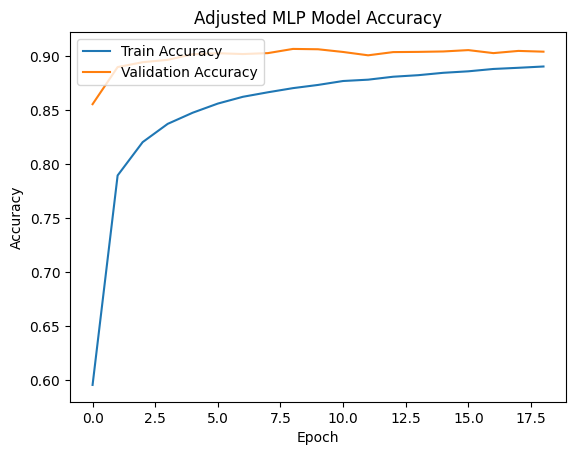

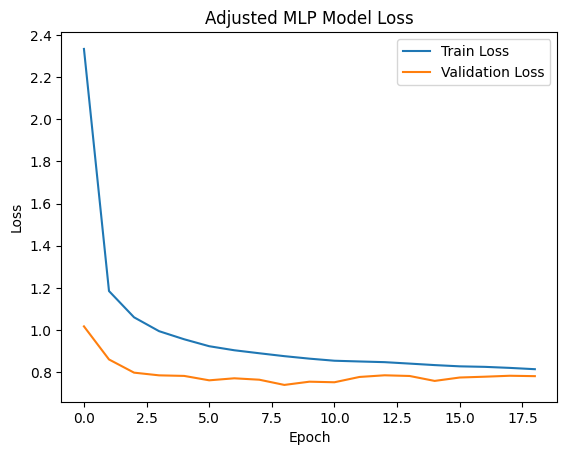

6476/6476 [==============================] - 12s 2ms/step
Adjusted MLP Train Accuracy: 0.9547939718861742


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report for the Adjusted MLP Model on Training Data:

              precision    recall  f1-score   support

         ADJ       0.92      0.96      0.94     13156
         ADP       0.89      0.98      0.93     17797
         ADV       0.92      0.84      0.88     10104
         AUX       0.97      0.98      0.98     12817
       CCONJ       0.98      0.99      0.99      6688
         DET       0.98      0.99      0.98     16300
        INTJ       0.69      0.02      0.03       695
        NOUN       0.96      0.97      0.97     34803
         NUM       0.97      0.98      0.97      4127
        PART       0.96      0.99      0.97      5748
        PRON       0.97      0.98      0.98     18661
       PROPN       0.93      0.92      0.93     12620
       PUNCT       0.98      1.00      0.99     23597
       SCONJ       0.88      0.57      0.70      3822
         SYM       0.96      0.22      0.35       721
        VERB       0.97      0.97      0.97     22604
           X

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


796/796 [==============================] - 2s 2ms/step
Adjusted MLP Test Accuracy: 0.9089194499017682

Classification Report for the Adjusted MLP Model on Test Data:

              precision    recall  f1-score   support

         ADJ       0.90      0.91      0.91      1788
         ADP       0.88      0.97      0.92      2034
         ADV       0.90      0.82      0.86      1176
         AUX       0.96      0.97      0.97      1543
       CCONJ       0.98      0.99      0.99       737
         DET       0.98      0.98      0.98      1897
        INTJ       1.00      0.02      0.03       120
        NOUN       0.82      0.93      0.87      4137
         NUM       0.89      0.68      0.77       542
        PART       0.92      0.98      0.95       649
        PRON       0.96      0.98      0.97      2162
       PROPN       0.81      0.70      0.75      2077
       PUNCT       0.98      0.99      0.98      3096
       SCONJ       0.88      0.52      0.65       384
         SYM       0.9

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Building the adjusted MLP model with increased regularization and dropout
adjusted_mlp_model = Sequential([
    # Adding input layer
    Input(shape=(window_size,), dtype='int32', name='Input_Layer'),

    # Adding embedding layer
    Embedding(input_dim=embedding_matrix.shape[0], output_dim=300, weights=[embedding_matrix], input_length=window_size, trainable=True),

    # Flattening the embeddings
    Flatten(),

    # Adding dense layers with dropout and regularization
    Dense(256, activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.8),
    Dense(128, activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.8),

    # Adding output layer
    Dense(len(train_target), activation='softmax')
])

# Printing the model summary for verification
print(adjusted_mlp_model.summary())

# Compiling the adjusted MLP model
adjusted_mlp_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[CategoricalAccuracy()])

# Custom callback for additional metrics
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = np.argmax(self.validation_data[1], -1)

        _val_f1 = f1_score(val_targ, val_predict, average="weighted")
        _val_recall = recall_score(val_targ, val_predict, average="weighted")
        _val_precision = precision_score(val_targ, val_predict, average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(f" — val_f1: {_val_f1:.4f} — val_precision: {_val_precision:.4f} — val_recall: {_val_recall:.4f}")
        return

# Setting up early stopping callback
early_stopping = EarlyStopping(patience=10, verbose=2, restore_best_weights=True, monitor='val_loss', mode='min')

# Training the adjusted MLP model
history = adjusted_mlp_model.fit(
    np.array(train_windows_tokenized), train_tags_onehot,
    validation_data=(np.array(dev_windows_tokenized), dev_tags_onehot),
    batch_size=256, epochs=100, shuffle=True,
    callbacks=[Metrics(valid_data=(np.array(dev_windows_tokenized), dev_tags_onehot)), early_stopping]
)

# Plotting training and validation accuracy
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Adjusted MLP Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Adjusted MLP Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Evaluating the adjusted MLP model on the training set
train_predictions_adjusted_mlp = adjusted_mlp_model.predict(np.array(train_windows_tokenized))
train_predictions_adjusted_mlp = np.argmax(train_predictions_adjusted_mlp, axis=-1)

# Converting one-hot encoded tags back to their original form for comparison
flat_train_tags_encoded = label_encoder.transform(list_flat_data(train_tags))

# Calculating accuracy on the training set
adjusted_mlp_train_accuracy = accuracy_score(flat_train_tags_encoded, train_predictions_adjusted_mlp)
print(f"Adjusted MLP Train Accuracy: {adjusted_mlp_train_accuracy}")

# Generating a classification report for the adjusted MLP model on training data
adjusted_mlp_train_classification_report = classification_report(flat_train_tags_encoded, train_predictions_adjusted_mlp, target_names=label_encoder.classes_)
print("\nClassification Report for the Adjusted MLP Model on Training Data:\n")
print(adjusted_mlp_train_classification_report)

# Evaluating the adjusted MLP model on the development set
dev_predictions_adjusted_mlp = adjusted_mlp_model.predict(np.array(dev_windows_tokenized))
dev_predictions_adjusted_mlp = np.argmax(dev_predictions_adjusted_mlp, axis=-1)

# Converting one-hot encoded tags back to their original form for comparison
flat_dev_tags_encoded = label_encoder.transform(list_flat_data(dev_tags))

# Calculating accuracy on the development set
adjusted_mlp_dev_accuracy = accuracy_score(flat_dev_tags_encoded, dev_predictions_adjusted_mlp)
print(f"Adjusted MLP Development Accuracy: {adjusted_mlp_dev_accuracy}")

# Generating a classification report for the adjusted MLP model on development data
adjusted_mlp_dev_classification_report = classification_report(flat_dev_tags_encoded, dev_predictions_adjusted_mlp, target_names=label_encoder.classes_)
print("\nClassification Report for the Adjusted MLP Model on Development Data:\n")
print(adjusted_mlp_dev_classification_report)

# Evaluating the adjusted MLP model on the test set
test_predictions_adjusted_mlp = adjusted_mlp_model.predict(np.array(test_windows_tokenized))
test_predictions_adjusted_mlp = np.argmax(test_predictions_adjusted_mlp, axis=-1)

# Converting one-hot encoded tags back to their original form for comparison
flat_test_tags_encoded = label_encoder.transform(list_flat_data(test_tags))

# Calculating accuracy on the test set
adjusted_mlp_test_accuracy = accuracy_score(flat_test_tags_encoded, test_predictions_adjusted_mlp)
print(f"Adjusted MLP Test Accuracy: {adjusted_mlp_test_accuracy}")

# Generating a classification report for the adjusted MLP model on test data
adjusted_mlp_test_classification_report = classification_report(flat_test_tags_encoded, test_predictions_adjusted_mlp, target_names=label_encoder.classes_)
print("\nClassification Report for the Adjusted MLP Model on Test Data:\n")
print(adjusted_mlp_test_classification_report)

## Implementing Bi-Directional Stacked RNN

### Defining the bi-directional stacked RNN model using GRU cells, incorporating dropout for regularization and compiling the model with appropriate loss function and optimizer

In [ ]:
# Defining hyperparameters
MAX_SEQUENCE_LENGTH = window_size  # Setting the window size as the sequence length
EMBEDDING_DIM = 300  # Defining the dimensionality of the embeddings
LSTM_UNITS = 512  # Defining the number of units in the LSTM layer
DROPOUT_RATE = 0.5  # Setting the dropout rate for regularization
NUM_CLASSES = len(set(list_flat_data(train_tags)))  # Calculating the number of unique POS tags

# Building the Bi-Directional Stacked RNN model
def build_model(vocab_size, embedding_matrix, input_length, num_classes, embedding_dim=300, lstm_units=128, dropout_rate=0.5):
    model = Sequential()

    # Adding input layer with the specified maximum sequence length
    model.add(Input(shape=(input_length,), dtype='int32'))

    # Adding embedding layer
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        trainable=False))

    # Adding dropout layer for regularization
    model.add(Dropout(dropout_rate))

    # Adding bidirectional LSTM layers
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True, recurrent_dropout=dropout_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=False, recurrent_dropout=dropout_rate)))
    model.add(Dropout(dropout_rate))

    # Adding fully connected layer with ReLU activation
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(dropout_rate))

    # Adding output layer with softmax activation for POS tagging
    model.add(Dense(units=num_classes, activation='softmax'))

    # Compiling the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Building the model by calling the build_model function
model = build_model(vocab_size=len(vocabulary),
                    embedding_matrix=embedding_matrix,
                    input_length=MAX_SEQUENCE_LENGTH,
                    num_classes=NUM_CLASSES,
                    embedding_dim=EMBEDDING_DIM,
                    lstm_units=LSTM_UNITS,
                    dropout_rate=DROPOUT_RATE)

# Printing the model summary for verification
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5, 300)            5965200   
                                                                 
 dropout_2 (Dropout)         (None, 5, 300)            0         
                                                                 
 bidirectional (Bidirection  (None, 5, 1024)           3330048   
 al)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 5, 1024)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 1024)              6295552   
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 1024)             

## Model Training and Hyperparameter Tuning

In [ ]:
# Custom callback for additional metrics
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        # Predicting validation data
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = np.argmax(self.validation_data[1], -1)

        # Calculating weighted F1 score
        _val_f1 = f1_score(val_targ, val_predict, average="weighted")
        # Calculating weighted recall score
        _val_recall = recall_score(val_targ, val_predict, average="weighted")
        # Calculating weighted precision score
        _val_precision = precision_score(val_targ, val_predict, average="weighted")

        # Logging the calculated metrics
        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(f" — val_f1: {_val_f1:.4f} — val_precision: {_val_precision:.4f} — val_recall: {_val_recall:.4f}")
        return

# Suppressing specific warning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Training the model
history = model.fit(
    np.array(train_windows_tokenized), train_tags_onehot,
    validation_data=(np.array(dev_windows_tokenized), dev_tags_onehot),
    batch_size=64,
    epochs=50,
    callbacks=[Metrics(valid_data=(np.array(dev_windows_tokenized), dev_tags_onehot)), early_stopping],
    verbose=1
)

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Epoch 1/50
798/798 [==============================] - 8s 10ms/step
 — val_f1: 0.8248 — val_precision: 0.8393 — val_recall: 0.8325
3238/3238 [==============================] - 284s 84ms/step - loss: 1.0704 - accuracy: 0.6758 - val_loss: 0.5137 - val_accuracy: 0.8325 - val_f1: 0.8248 - val_recall: 0.8325 - val_precision: 0.8393
Epoch 2/50
798/798 [==============================] - 7s 9ms/step
 — val_f1: 0.8451 — val_precision: 0.8624 — val_recall: 0.8518
3238/3238 [==============================] - 271s 84ms/step - loss: 0.6315 - accuracy: 0.8086 - val_loss: 0.4554 - val_accuracy: 0.8518 - val_f1: 0.8451 - val_recall: 0.8518 - val_precision: 0.8624
Epoch 3/50
798/798 [==============================] - 7s 9ms/step
 — val_f1: 0.8553 — val_precision: 0.8726 — val_recall: 0.8626
3238/3238 [==============================] - 269s 83ms/step - loss: 0.5470 - accuracy: 0.8330 - val_loss: 0.4160 - val_accuracy: 0.8626 - val_f1: 0.8553 - val_recall: 0.8626 - val_precision: 0.8726
Epoch 4/50
798/798

## Model Evaluation

In [ ]:
# Evaluating the model on the test set
test_windows_tokenized = tokenize_windows(test_windows, vocabulary)

# Predicting tags for the test set
test_predictions = model.predict(np.array(test_windows_tokenized))
test_predictions = np.argmax(test_predictions, axis=-1)

# Converting one-hot encoded tags back to their original form
flat_test_tags = list_flat_data(test_tags)
flat_test_tags_encoded = label_encoder.transform(flat_test_tags)

# Calculating accuracy
test_accuracy = accuracy_score(flat_test_tags_encoded, test_predictions)
print(f"Test Accuracy: {test_accuracy}")

# Generating a classification report
test_classification_report = classification_report(flat_test_tags_encoded, test_predictions, target_names=label_encoder.classes_)
print("\nClassification Report for the Test Set:\n")
print(test_classification_report)

In [ ]:
# Calculating Precision-Recall AUC for each class
# Getting the predicted probabilities
test_predictions_prob_rnn = model.predict(np.array(test_windows_tokenized))

# Calculating the number of rows and columns for the subplot grid
num_classes = len(label_encoder.classes_)
num_cols = 4
num_rows = (num_classes + num_cols - 1) // num_cols  # Calculate number of rows needed

# Creating a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flattening axes array for easy iteration
axes = axes.flatten()

# Calculating Precision-Recall AUC for each class and plotting the Precision-Recall curve
for i, class_name in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(flat_test_tags_encoded == i, test_predictions_prob_rnn[:, i])
    pr_auc = auc(recall, precision)
    print(f'Class {class_name}: Precision-Recall AUC = {pr_auc:.4f}')

    # Plotting the Precision-Recall curve in the corresponding subplot
    axes[i].plot(recall, precision, label=f'AUC={pr_auc:.4f}')
    axes[i].set_title(f'Class {class_name}')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlim([0.0, 1.0])
    axes[i].legend(loc="lower left")

# Removing any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjusting layout
plt.tight_layout()
plt.show()